Reference:

[Autograd Api Doc](https://pytorch.org/docs/stable/autograd.html)

[Back propagation](https://medium.com/ai-academy-taiwan/back-propagation-3946e8ed8c55)


[Introduction](introyt1_tutorial.html) ||
[Tensors](tensors_deeper_tutorial.html) ||
**Autograd** ||
[Building Models](modelsyt_tutorial.html) ||
[TensorBoard Support](tensorboardyt_tutorial.html) ||
[Training Models](trainingyt.html) ||
[Model Understanding](captumyt.html)

# The Fundamentals of Autograd

Follow along with the video below or on [youtube](https://www.youtube.com/watch?v=M0fX15_-xrY)_.

.. raw:: html

   <div style="margin-top:10px; margin-bottom:10px;">
     <iframe width="560" height="315" src="https://www.youtube.com/embed/M0fX15_-xrY" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
   </div>

PyTorch’s *Autograd* feature is part of what make PyTorch flexible and
fast for building machine learning projects. It allows for the rapid and
easy computation of multiple partial derivatives (also referred to as
*gradients)* over a complex computation. This operation is central to
backpropagation-based neural network learning.

The power of autograd comes from the fact that it traces your
computation dynamically *at runtime,* meaning that if your model has
decision branches, or loops whose lengths are not known until runtime,
the computation will still be traced correctly, and you’ll get correct
gradients to drive learning. This, combined with the fact that your
models are built in Python, offers far more flexibility than frameworks
that rely on static analysis of a more rigidly-structured model for
computing gradients.

## What Do We Need Autograd For?


A machine learning model is a *function*, with inputs and outputs. For
this discussion, we’ll treat the inputs as an *i*-dimensional vector
$\vec{x}$, with elements $x_{i}$. We can then express the
model, *M*, as a vector-valued function of the input: $\vec{y} =
\vec{M}(\vec{x})$. (We treat the value of M’s output as
a vector because in general, a model may have any number of outputs.)

Since we’ll mostly be discussing autograd in the context of training,
our output of interest will be the model’s loss. The *loss function*
L($\vec{y}$) = L($\vec{M}$\ ($\vec{x}$)) is a
single-valued scalar function of the model’s output. This function
expresses how far off our model’s prediction was from a particular
input’s *ideal* output. *Note: After this point, we will often omit the
vector sign where it should be contextually clear - e.g.,* $y$
instead of $\vec y$.

In training a model, we want to minimize the loss. In the idealized case
of a perfect model, that means adjusting its learning weights - that is,
the adjustable parameters of the function - such that loss is zero for
all inputs. In the real world, it means an iterative process of nudging
the learning weights until we see that we get a tolerable loss for a
wide variety of inputs.

How do we decide how far and in which direction to nudge the weights? We
want to *minimize* the loss, which means making its first derivative
with respect to the input equal to 0:
$\frac{\partial L}{\partial x} = 0$.

Recall, though, that the loss is not *directly* derived from the input,
but a function of the model’s output (which is a function of the input
directly), $\frac{\partial L}{\partial x}$ =
$\frac{\partial {L({\vec y})}}{\partial x}$. By the chain rule of
differential calculus, we have
$\frac{\partial {L({\vec y})}}{\partial x}$ =
$\frac{\partial L}{\partial y}\frac{\partial y}{\partial x}$ =
$\frac{\partial L}{\partial y}\frac{\partial M(x)}{\partial x}$.

$\frac{\partial M(x)}{\partial x}$ is where things get complex.
The partial derivatives of the model’s outputs with respect to its
inputs, if we were to expand the expression using the chain rule again,
would involve many local partial derivatives over every multiplied
learning weight, every activation function, and every other mathematical
transformation in the model. The full expression for each such partial
derivative is the sum of the products of the local gradient of *every
possible path* through the computation graph that ends with the variable
whose gradient we are trying to measure.

In particular, the gradients over the learning weights are of interest
to us - they tell us *what direction to change each weight* to get the
loss function closer to zero.

Since the number of such local derivatives (each corresponding to a
separate path through the model’s computation graph) will tend to go up
exponentially with the depth of a neural network, so does the complexity
in computing them. This is where autograd comes in: It tracks the
history of every computation. Every computed tensor in your PyTorch
model carries a history of its input tensors and the function used to
create it. Combined with the fact that PyTorch functions meant to act on
tensors each have a built-in implementation for computing their own
derivatives, this greatly speeds the computation of the local
derivatives needed for learning.

## A Simple Example

That was a lot of theory - but what does it look like to use autograd in
practice?

Let’s start with a straightforward example. First, we’ll do some imports
to let us graph our results:




In [2]:
# %matplotlib inline

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

Next, we’ll create an input tensor full of evenly spaced values on the
interval $[0, 2{\pi}]$, and specify ``requires_grad=True``. (Like
most functions that create tensors, ``torch.linspace()`` accepts an
optional ``requires_grad`` option.) Setting this flag means that in
every computation that follows, autograd will be accumulating the
history of the computation in the output tensors of that computation.




In [3]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


Next, we’ll perform a computation, and plot its output in terms of its
inputs:




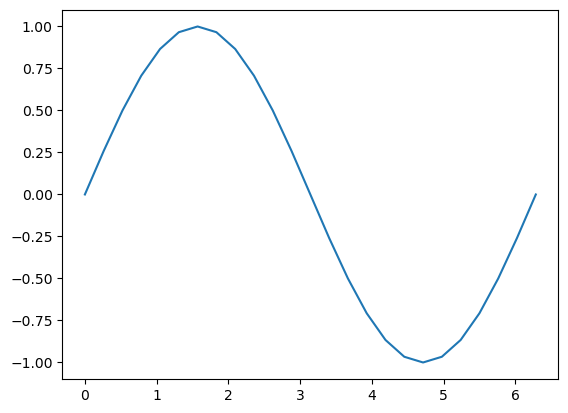

In [4]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

Let’s have a closer look at the tensor ``b``. When we print it, we see
an indicator that it is tracking its computation history:




In [5]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


This ``grad_fn`` gives us a hint that when we execute the
backpropagation step and compute gradients, we’ll need to compute the
derivative of $\sin(x)$ for all this tensor’s inputs.

Let’s perform some more computations:




In [6]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


Finally, let’s compute a single-element output. When you call
``.backward()`` on a tensor with no arguments, it expects the calling
tensor to contain only a single element, as is the case when computing a
loss function.




In [7]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


Each ``grad_fn`` stored with our tensors allows you to walk the
computation all the way back to its inputs with its ``next_functions``
property. We can see below that drilling down on this property on ``d``
shows us the gradient functions for all the prior tensors. Note that
``a.grad_fn`` is reported as ``None``, indicating that this was an input
to the function with no history of its own.




In [8]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x0000021DE0D6A860>, 0), (None, 0))
((<SinBackward0 object at 0x0000021DE0D6B7F0>, 0), (None, 0))
((<AccumulateGrad object at 0x0000021DE0D6A890>, 0),)
()

c:

b:

a:
None


With all this machinery in place, how do we get derivatives out? You
call the ``backward()`` method on the output, and check the input’s
``grad`` property to inspect the gradients:




tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


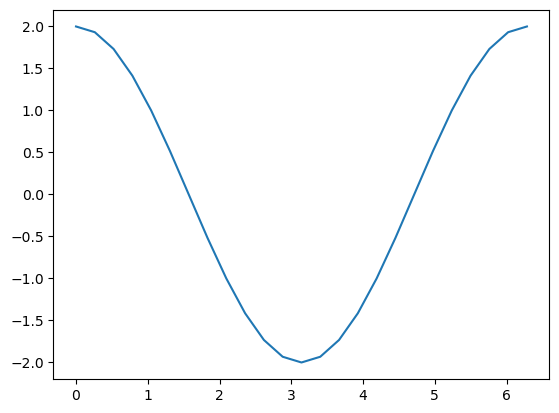

In [9]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

Recall the computation steps we took to get here:

::

   a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
   b = torch.sin(a)
   c = 2 * b
   d = c + 1
   out = d.sum()

Adding a constant, as we did to compute ``d``, does not change the
derivative. That leaves $c = 2 * b = 2 * \sin(a)$, the derivative
of which should be $2 * \cos(a)$. Looking at the graph above,
that’s just what we see.

Be aware that only *leaf nodes* of the computation have their gradients
computed. If you tried, for example, ``print(c.grad)`` you’d get back
``None``. In this simple example, only the input is a leaf node, so only
it has gradients computed.

## Autograd in Training

We’ve had a brief look at how autograd works, but how does it look when
it’s used for its intended purpose? Let’s define a small model and
examine how it changes after a single training batch. First, define a
few constants, our model, and some stand-ins for inputs and outputs:




In [10]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
        
        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
    
some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

One thing you might notice is that we never specify
``requires_grad=True`` for the model’s layers. Within a subclass of
``torch.nn.Module``, it’s assumed that we want to track gradients on the
layers’ weights for learning.

If we look at the layers of the model, we can examine the values of the
weights, and verify that no gradients have been computed yet:




In [11]:
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

tensor([-1.6579e-02, -3.3614e-03,  3.3109e-02,  8.9307e-02,  9.7227e-02,
         5.2735e-05,  8.5557e-02, -9.1030e-02, -4.9228e-02, -3.6062e-02],
       grad_fn=<SliceBackward0>)
None


Let’s see how this changes when we run through one training batch. For a
loss function, we’ll just use the square of the Euclidean distance
between our ``prediction`` and the ``ideal_output``, and we’ll use a
basic stochastic gradient descent optimizer.




In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(148.2732, grad_fn=<SumBackward0>)


Now, let’s call ``loss.backward()`` and see what happens:




In [13]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-1.6579e-02, -3.3614e-03,  3.3109e-02,  8.9307e-02,  9.7227e-02,
         5.2735e-05,  8.5557e-02, -9.1030e-02, -4.9228e-02, -3.6062e-02],
       grad_fn=<SliceBackward0>)
tensor([-1.0369,  0.8840,  1.3119,  2.4188,  0.9102,  1.5746, -1.0075, -1.3730,
        -0.2442,  0.1787])


We can see that the gradients have been computed for each learning
weight, but the weights remain unchanged, because we haven’t run the
optimizer yet. The optimizer is responsible for updating model weights
based on the computed gradients.




In [14]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0155, -0.0042,  0.0318,  0.0869,  0.0963, -0.0015,  0.0866, -0.0897,
        -0.0490, -0.0362], grad_fn=<SliceBackward0>)
tensor([-1.0369,  0.8840,  1.3119,  2.4188,  0.9102,  1.5746, -1.0075, -1.3730,
        -0.2442,  0.1787])


You should see that ``layer2``\ ’s weights have changed.

One important thing about the process: After calling
``optimizer.step()``, you need to call ``optimizer.zero_grad()``, or
else every time you run ``loss.backward()``, the gradients on the
learning weights will accumulate:




In [15]:
print(model.layer2.weight.grad[0][0:10])

for i in range(0, 5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()
    
print(model.layer2.weight.grad[0][0:10])

optimizer.zero_grad(set_to_none=False)

print(model.layer2.weight.grad[0][0:10])

tensor([-1.0369,  0.8840,  1.3119,  2.4188,  0.9102,  1.5746, -1.0075, -1.3730,
        -0.2442,  0.1787])
tensor([ -2.0633,   0.8807,   2.3336,   0.2436,  -8.7216,  16.6341, -10.9357,
         12.1527,  -1.1069,  20.1291])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


After running the cell above, you should see that after running
``loss.backward()`` multiple times, the magnitudes of most of the
gradients will be much larger. Failing to zero the gradients before
running your next training batch will cause the gradients to blow up in
this manner, causing incorrect and unpredictable learning results.

## Turning Autograd Off and On

There are situations where you will need fine-grained control over
whether autograd is enabled. There are multiple ways to do this,
depending on the situation.

The simplest is to change the ``requires_grad`` flag on a tensor
directly:




In [16]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


In the cell above, we see that ``b1`` has a ``grad_fn`` (i.e., a traced
computation history), which is what we expect, since it was derived from
a tensor, ``a``, that had autograd turned on. When we turn off autograd
explicitly with ``a.requires_grad = False``, computation history is no
longer tracked, as we see when we compute ``b2``.

If you only need autograd turned off temporarily, a better way is to use
the ``torch.no_grad()``:




In [17]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


``torch.no_grad()`` can also be used as a function or method decorator:




In [18]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


There’s a corresponding context manager, ``torch.enable_grad()``, for
turning autograd on when it isn’t already. It may also be used as a
decorator.

Finally, you may have a tensor that requires gradient tracking, but you
want a copy that does not. For this we have the ``Tensor`` object’s
``detach()`` method - it creates a copy of the tensor that is *detached*
from the computation history:




In [19]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.4224, 0.7423, 0.2241, 0.3141, 0.6193], requires_grad=True)
tensor([0.4224, 0.7423, 0.2241, 0.3141, 0.6193])


We did this above when we wanted to graph some of our tensors. This is
because ``matplotlib`` expects a NumPy array as input, and the implicit
conversion from a PyTorch tensor to a NumPy array is not enabled for
tensors with requires_grad=True. Making a detached copy lets us move
forward.

### Autograd and In-place Operations

In every example in this notebook so far, we’ve used variables to
capture the intermediate values of a computation. Autograd needs these
intermediate values to perform gradient computations. *For this reason,
you must be careful about using in-place operations when using
autograd.* Doing so can destroy information you need to compute
derivatives in the ``backward()`` call. PyTorch will even stop you if
you attempt an in-place operation on leaf variable that requires
autograd, as shown below.

<div class="alert alert-info"><h4>Note</h4><p>The following code cell throws a runtime error. This is expected.</p></div>

::

   a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
   torch.sin_(a)




## Autograd Profiler

Autograd tracks every step of your computation in detail. Such a
computation history, combined with timing information, would make a
handy profiler - and autograd has that feature baked in. Here’s a quick
example usage:




In [20]:
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True
    
x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

with torch.autograd.profiler.profile(use_cuda=run_on_gpu) as prf:
    for _ in range(1000):
        z = (z / x) * y
        
print(prf.key_averages().table(sort_by='self_cpu_time_total'))

-------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::div        52.67%      32.212ms        52.67%      32.212ms      32.212us      66.956ms        51.64%      66.956ms      66.956us          1000  
    aten::mul        47.33%      28.950ms        47.33%      28.950ms      28.950us      62.702ms        48.36%      62.702ms      62.702us          1000  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 61.162ms
Self CUDA time total: 129.658ms



The profiler can also label individual sub-blocks of code, break out the
data by input tensor shape, and export data as a Chrome tracing tools
file. For full details of the API, see the
[documentation](https://pytorch.org/docs/stable/autograd.html#profiler)_.

## Advanced Topic: More Autograd Detail and the High-Level API

If you have a function with an n-dimensional input and m-dimensional
output, $\vec{y}=f(\vec{x})$, the complete gradient is a matrix of
the derivative of every output with respect to every input, called the
*Jacobian:*

\begin{align}J
     =
     \left(\begin{array}{ccc}
     \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
     \vdots & \ddots & \vdots\\
     \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
     \end{array}\right)\end{align}

If you have a second function, $l=g\left(\vec{y}\right)$ that
takes m-dimensional input (that is, the same dimensionality as the
output above), and returns a scalar output, you can express its
gradients with respect to $\vec{y}$ as a column vector,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$
- which is really just a one-column Jacobian.

More concretely, imagine the first function as your PyTorch model (with
potentially many inputs and many outputs) and the second function as a
loss function (with the model’s output as input, and the loss value as
the scalar output).

If we multiply the first function’s Jacobian by the gradient of the
second function, and apply the chain rule, we get:

\begin{align}J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)\end{align}

Note: You could also use the equivalent operation $v^{T}\cdot J$,
and get back a row vector.

The resulting column vector is the *gradient of the second function with
respect to the inputs of the first* - or in the case of our model and
loss function, the gradient of the loss with respect to the model
inputs.

**``torch.autograd`` is an engine for computing these products.** This
is how we accumulate the gradients over the learning weights during the
backward pass.

For this reason, the ``backward()`` call can *also* take an optional
vector input. This vector represents a set of gradients over the tensor,
which are multiplied by the Jacobian of the autograd-traced tensor that
precedes it. Let’s try a specific example with a small vector:




In [21]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([1040.0310, 1427.7225, -371.8192], grad_fn=<MulBackward0>)


If we tried to call ``y.backward()`` now, we’d get a runtime error and a
message that gradients can only be *implicitly* computed for scalar
outputs. For a multi-dimensional output, autograd expects us to provide
gradients for those three outputs that it can multiply into the
Jacobian:




In [22]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float) # stand-in for gradients
y.backward(v)

print(x.grad)

tensor([2.0480e+02, 2.0480e+03, 2.0480e-01])


(Note that the output gradients are all related to powers of two - which
we’d expect from a repeated doubling operation.)

### The High-Level API

There is an API on autograd that gives you direct access to important
differential matrix and vector operations. In particular, it allows you
to calculate the Jacobian and the *Hessian* matrices of a particular
function for particular inputs. (The Hessian is like the Jacobian, but
expresses all partial *second* derivatives.) It also provides methods
for taking vector products with these matrices.

Let’s take the Jacobian of a simple function, evaluated for a 2
single-element inputs:




In [23]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.8745]), tensor([0.1360]))


(tensor([[4.7954]]), tensor([[3.]]))

If you look closely, the first output should equal $2e^x$ (since
the derivative of $e^x$ is $e^x$), and the second value
should be 3.

You can, of course, do this with higher-order tensors:




In [24]:
inputs = (torch.rand(3), torch.rand(3)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.1413, 0.1640, 0.1627]), tensor([0.4995, 0.8008, 0.6985]))


(tensor([[2.3034, 0.0000, 0.0000],
         [0.0000, 2.3564, 0.0000],
         [0.0000, 0.0000, 2.3533]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

The ``torch.autograd.functional.hessian()`` method works identically
(assuming your function is twice differentiable), but returns a matrix
of all second derivatives.

There is also a function to directly compute the vector-Jacobian
product, if you provide the vector:




In [25]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([1434.9110, 1338.4712,  -29.8519]),
 tensor([2.0480e+02, 2.0480e+03, 2.0480e-01]))

The ``torch.autograd.functional.jvp()`` method performs the same matrix
multiplication as ``vjp()`` with the operands reversed. The ``vhp()``
and ``hvp()`` methods do the same for a vector-Hessian product.

For more information, including performance notes on the [docs for the
functional
API](https://pytorch.org/docs/stable/autograd.html#functional-higher-level-api)_


